In [1]:
import ROOT as R

Welcome to JupyROOT 6.22/00


In [89]:
import os
import math
from pycode.utils import read_root_obj

In [94]:
def draw(histos, config, out_file=None):
    size = (800, 800)
    if 'canvas' in config:
        size = config['canvas']
    C = R.TCanvas("canvas", "", size[0], size[1])
    C.SetGridx()
    C.SetGridy()
    R.SetOwnership(C, False)
    n = len(histos)
    leg = None
    if 'leg' in config:
        leg = R.TLegend(0.7,0.95 - 1*len(config['leg'])*0.06, 0.9,0.9)
        leg.SetMargin(0.2)
        leg.SetTextSize(0.03)
        leg.SetNColumns(1)
        R.SetOwnership(leg, 0)
    h_axis = None
    h_toDraw = []
    for iH, h_ori in enumerate(histos):
        h = h_ori.Clone()
        if iH == 0:
            h_axis = h
        if 'rebin' in config:
            h.Rebin(config['rebin'])
#         h.Rebin(2)
        if 'norm' in config:
            h.Scale(config['norm'] / h.Integral())
        R.SetOwnership(h, 0)
        h.SetLineWidth(2)
        if 'style' in config:
            h.SetLineStyle(config['style'][iH])
        h.SetLineColor(config['color'][iH])
#         h.SetLineColor(1)
#         h.SetFillColor(config['color'][iH])
        if leg and len(config['leg']) > iH:
#             leg.AddEntry(h, config['leg'][iH], 'l')
            leg.AddEntry(h, config['leg'][iH], 'l').SetTextColor(config['color'][iH])
        h_toDraw.append(h)
    # Actually drawing
    h_axis.Draw('AXIS')
    h_axis.Draw('AXIG same')
    for iH, h in enumerate(h_toDraw):
        drawopt = 'hist'
        if 'drawopt' in config:
            drawopt = config['drawopt']
        drawopt += "same"
        h.Draw(drawopt)
    h_axis.Draw('AXIG same')
    if leg:
        leg.Draw()
        h_axis.GetYaxis().SetMaxDigits(4)
    if 'y' in config:
        h_axis.GetYaxis().SetRangeUser(*config['y'])
    if 'x' in config:
        h_axis.GetXaxis().SetRangeUser(*config['x'])
    if 'logY' in config:
        C.SetLogy(config['logY'])
    if 'logX' in config:
        C.SetLogx(config['logX'])
    C.RedrawAxis()
    C.Draw()
    if out_file:
        C.Print(out_file)
    return C

In [103]:
R.gStyle.SetOptStat(0)
R.gStyle.SetPadLeftMargin(0.12)
R.gStyle.SetGridColor(16)

In [236]:
styles = [1,1,1,1]
colors = [12, 2, R.kAzure+7, R.kTeal+2, 2]
DIR_IN = '/Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies'
FILES_IN = [os.path.join(DIR_IN, 'bib_digi', f'{p}.root') for p in [
    'pgun_mu_1per100k_4pt_j2', 'pgun_mu_1per100k_4pt_mod2_j2'
#     'pgun_dummy_merge_v1', 'pgun_dummy_merge_v1_mod2'
#     'pgun_mu_1per10k_4pt_j2'
#     'pgun_dummy_merge_v1_mod2', 'pgun_mu_1per10k_4pt_mod2_j2'
]]

In [283]:
histos = []
for iL, layer in enumerate(['0_1', '2_3', '4_5', '6_7']):
    f_in = R.TFile(FILES_IN[1])
    h = read_root_obj(f_in, f'FilterDL_VXDE/h_dPhi_layers_{layer}')
#     h = read_root_obj(f_in, f'FilterDL_VXDB/h_dTheta_layers_{layer}')
#     h.GetYaxis().SetTitle('Hit pairs [%]')
#     h.Rebin(10)
    histos.append(h)

In [284]:
thresholds = []
fit_func = R.TF1('f1', 'gaus', 0, 10)
for iH, h in enumerate(histos):
    fit_res = h.Fit(fit_func, 'RQN0S')
    thr = fit_func.GetParameter(1) + 3*fit_func.GetParameter(2)
    thresholds.append(thr)
    line = R.TLine(thr, 0, thr, y_max)
    line.SetLineStyle(7)
    line.SetLineWidth(2)
    R.SetOwnership(line, False)
    line.SetLineColor(colors[iH])
    lines.append(line)

In [285]:
y_max = 3000
# thresholds = [2.25, 1.98, 1.84, 1.76]
# thresholds = [1.81, 1.54, 1.40, 1.32]
lines = []
for iT, thr in enumerate(thresholds):
    line = R.TLine(thr, 0, thr, y_max)
    line.SetLineStyle(7)
    line.SetLineWidth(2)
    R.SetOwnership(line, False)
    line.SetLineColor(colors[iT])
    lines.append(line)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file /Users/nbartosi/cernbox/work/mu_collider/data/2022_06_17_vxd_studies/plots/dPhi_cuts_endcap_v1_mod2.pdf has been created


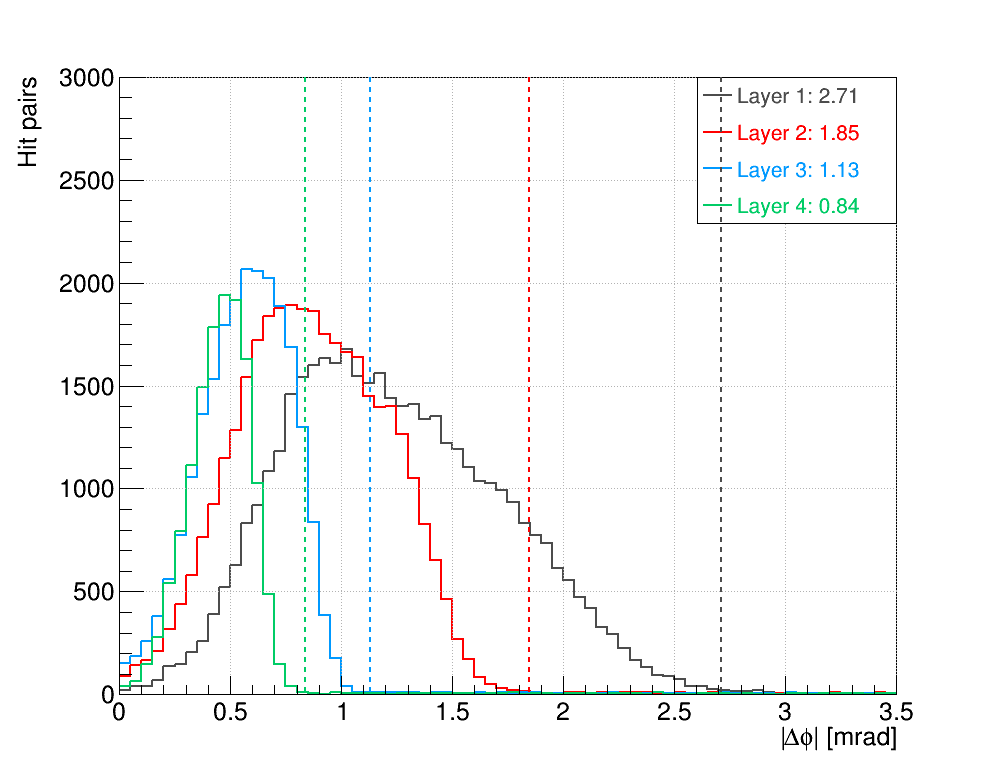

In [286]:
# y_max = 1000
config = {
    'canvas': (1000, 800),
    'style': styles,
    'color': colors,
    'leg': [f'Layer {l}: {thresholds[iL]:.2f}' for iL, l in enumerate(range(1, 4+1))],
    'x': (0, 3.5),
#     'x': (0, 30),
    'y': (0, y_max),
    'logY': False,
}
# out_path = os.path.join(DIR_IN, 'plots', 'dPhi_l23_pt1GeV_v1.pdf')
out_path = None
C = draw(histos, config, out_path)
# Adding threshold lines at +3sigma
for line in lines:
    line.Draw()
R.gPad.Print(os.path.join(DIR_IN, 'plots', 'dPhi_cuts_endcap_v1_mod2.pdf'))